# Library Imports

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
import time
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

# Bike Data DB

In [2]:
# Define the Filepath for the Dataset
filepath = 'OPENDATA_BOOKING_CALL_A_BIKE.csv'

# Define the Chunksize
chunksize = 10 ** 6

# Define the specific Timerange 
date_after = pd.Timestamp('2013-12-31 23:59:59')
date_before = pd.Timestamp('2016-01-01 00:00:00')

# Define the Columns that contain Dates
dates_from_data = ['DATE_BOOKING',
                   'DATE_FROM',
                   'DATE_UNTIL']

# Define the columns that are needed from the Dataset
needed_cols = ['DATE_BOOKING' ,
               'DATE_FROM',
               'DATE_UNTIL',
               'START_RENTAL_ZONE',
               'END_RENTAL_ZONE',
               'CITY_RENTAL_ZONE']

# Definition that imports the dataset in Chunks of 1,000,000 rows to not clog the Memory
def load_csv():
    
    data_iterator = pd.read_csv(filepath,
                                chunksize=chunksize,
                                sep=';',
                                parse_dates=dates_from_data,
                                usecols=needed_cols)
    chunk_list = []  

    # Each chunk is in dataframe format
    for data_chunk in data_iterator:  
        # Filter the Data for the City Hamburg and the given Time Horizon
        filtered_chunk = data_chunk[(data_chunk['CITY_RENTAL_ZONE'] == 'Hamburg') &
                                    (data_chunk['DATE_UNTIL'] > date_after) &
                                    (data_chunk['DATE_UNTIL'] < date_before)]
        # Append the chunk into a list, so we have the continued data
        chunk_list.append(filtered_chunk)
    filtered_data = pd.concat(chunk_list)
    return filtered_data

# Time how long it takes to load the Bike Dataset and insert it into the bike_data variable
%time bike_data = load_csv()

# Format the Dates from Object to DateTime Types
bike_data['DATE_BOOKING'] = pd.to_datetime(bike_data['DATE_BOOKING'],
                                                        format='%Y%m%d %H:%M:%S')
bike_data['DATE_FROM'] = pd.to_datetime(bike_data['DATE_FROM'],
                                                        format='%Y%m%d %H:%M:%S')
bike_data['DATE_UNTIL'] = pd.to_datetime(bike_data['DATE_UNTIL'],
                                                        format='%Y%m%d %H:%M:%S')

CPU times: user 1min 30s, sys: 13.7 s, total: 1min 44s
Wall time: 1min 46s


In [3]:
bike_data.index = bike_data.DATE_BOOKING

# Temperature Data


00954 UFS Deutsche Bucht    -- geoBreite = 54.1796   geoLaenge = 7.4587 North sea <br>
01228 UFS TW Ems            -- geoBreite = 54.1651   geoLaenge = 6.3460 Same as above <br>
01975 Hamburg-Fühlsbüttel   -- geoBreite = 53.6332   geoLaenge = 9.9881<br>
01981 Hamburg-Neuwiedenthal -- geoBreite = 53.4777   geoLaenge = 9.8957<br>
06254 Hamburg-Lotsenhöft    -- not available<br>
13904 Nordseeboje 2         -- only till 2010<br>

In [4]:
# Define the filepath for the Temperature Data derived from the German Weather Service Data (DWD)
filepath_temperature_dict = ['temperature_station_01975.csv', 'temperature_station_01981.csv']

# Read the .csv files from the stations 1975 and 1981
temperature_station_1975 = pd.read_csv(filepath_temperature_dict[0], sep=';',
                                       usecols=['STATIONS_ID','MESS_DATUM','TT_TU'])
temperature_station_1981 = pd.read_csv(filepath_temperature_dict[1], sep=';',
                                       usecols=['STATIONS_ID','MESS_DATUM','TT_TU'])

# Rename the columns to clearly know what they stand for
temperature_station_1975.columns = ['ID', 'DATE', 'TEMPERATURE']
temperature_station_1981.columns = ['ID', 'DATE', 'TEMPERATURE']

In [5]:
# Format the Dates from Object to DateTime Types
temperature_station_1975['DATE'] = pd.to_datetime(temperature_station_1975['DATE'],
                                                        format='%Y%m%d%H')
temperature_station_1981['DATE'] = pd.to_datetime(temperature_station_1981['DATE'],
                                                        format='%Y%m%d%H')


# Filter for the Data from 2014-2015
temperature_station_1975 = temperature_station_1975[(temperature_station_1975['DATE'] > date_after) 
                                                    &
                                                    (temperature_station_1975['DATE'] < date_before)]

temperature_station_1981 = temperature_station_1981[(temperature_station_1981['DATE'] > date_after) 
                                                    & 
                                                    (temperature_station_1981['DATE'] < date_before)]

# Reset the Indices so that we start at 0
temperature_station_1975.reset_index(drop=True, inplace=True)
temperature_station_1981.reset_index(drop=True, inplace=True)

#Check if we have all Data from the two Years (2 years * 365 days * 24 hours/day)
if len(temperature_station_1975) == (2 * 365 * 24):
    print('No data missing for station 1975!')
if len(temperature_station_1981) == (2 * 365 * 24):
    print('No data missing for station 1981!')

No data missing for station 1975!
No data missing for station 1981!


In [6]:
# Check for missing Values
print('Absolute values missing for station 1975 are: '
      ,temperature_station_1975['TEMPERATURE'][temperature_station_1975['TEMPERATURE'] == -999.0].count())

print('Absolute values missing for station 1981 are: '
      ,temperature_station_1981['TEMPERATURE'][temperature_station_1981['TEMPERATURE'] == -999.0].count())


Absolute values missing for station 1975 are:  0
Absolute values missing for station 1981 are:  1


In [7]:
# Handle missing Values by just using the other Stations Data at that exact Time 
# (obviously only works if the other Station has all the Data)

index_of_missing_value = temperature_station_1981.index[temperature_station_1981['TEMPERATURE'] ==-999.0]

temperature_station_1981.at[index_of_missing_value, 'TEMPERATURE'] = temperature_station_1975.loc[index_of_missing_value].TEMPERATURE

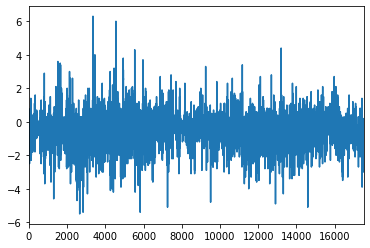

In [8]:
# Plot the difference between the two station to check,
# if we should take just one station for simplicity or take a mean of the two
check_station_differences = temperature_station_1975['TEMPERATURE'].subtract(temperature_station_1981['TEMPERATURE'])
check_station_differences.plot()

In [9]:
check_station_differences.describe()

count    17520.000000
mean        -0.506558
std          0.786722
min         -5.500000
25%         -0.900000
50%         -0.400000
75%         -0.100000
max          6.300000
Name: TEMPERATURE, dtype: float64

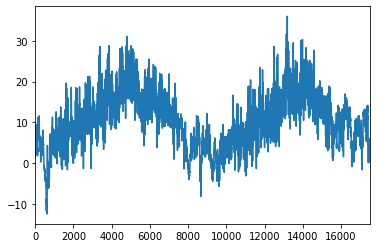

In [10]:
# The values are too far from each other in their maxima (>5 degrees)
# So we will complete the temperature data by taking the average of each station
temperature_data = pd.DataFrame({'DATE' : temperature_station_1975['DATE'],
                                 'TEMPERATURE': (temperature_station_1975['TEMPERATURE']
                                                 +temperature_station_1975['TEMPERATURE'])/2})

temperature_data['TEMPERATURE'].plot()

# Precipitation Data



In [338]:
# Define the Filepath for Stations 1975 and 1981
filepath_precipitation_dict = ['precipitation_station_01975.csv','precipitation_station_01981.csv']

# Read the .csv files from the stations 1975 and 1981
precipitation_station_1975 = pd.read_csv(filepath_precipitation_dict[0], sep=';', usecols=[0,1,3])
precipitation_station_1981 = pd.read_csv(filepath_precipitation_dict[1], sep=';', usecols=[0,1,3])

# Rename the columns to clearly know what they stand for
precipitation_station_1975.columns = ['ID','DATE','PRECIPITATION']
precipitation_station_1981.columns = ['ID','DATE','PRECIPITATION']

In [339]:
#Format the Dates from Object to DateTime Types
precipitation_station_1975['DATE'] = pd.to_datetime(precipitation_station_1975['DATE'], format='%Y%m%d%H')
precipitation_station_1981['DATE'] = pd.to_datetime(precipitation_station_1981['DATE'], format='%Y%m%d%H')

In [340]:
#Filter for the Data from 2014-2015
precipitation_station_1975 = precipitation_station_1975[(precipitation_station_1975['DATE'] > date_after) 
                                                        &
                                                        (precipitation_station_1975['DATE'] < date_before)]
precipitation_station_1981 = precipitation_station_1981[(precipitation_station_1981['DATE'] > date_after)
                                                        & 
                                                        (precipitation_station_1981['DATE'] < date_before)]

#Reset indices
precipitation_station_1975.reset_index(drop=True, inplace=True)
precipitation_station_1981.reset_index(drop=True, inplace=True)

In [341]:
# Check for missing values
print('Absolute values missing for station 1975 are: ',
      precipitation_station_1975['PRECIPITATION'][precipitation_station_1975['PRECIPITATION'] == -999.0].count())
print('Absolute values missing for station 1981 are: ',
      precipitation_station_1981['PRECIPITATION'][precipitation_station_1981['PRECIPITATION'] == -999.0].count())


Absolute values missing for station 1975 are:  20
Absolute values missing for station 1981 are:  0


In [342]:
# Handle missing value by just using the other stations data at that exact time
index_of_missing_value = precipitation_station_1975.index[precipitation_station_1975['PRECIPITATION'] ==-999.0]
value = precipitation_station_1981.loc[index_of_missing_value]['PRECIPITATION']
precipitation_station_1975.at[index_of_missing_value, 'PRECIPITATION'] = value


In [343]:
# Check if we handled all the missing values

print('Absolute values missing for station 1975 are: ',
      precipitation_station_1975['PRECIPITATION'][precipitation_station_1975['PRECIPITATION'] == -999.0].count())

Absolute values missing for station 1975 are:  0


In [344]:
# Check the count of the two datasets
print(len(precipitation_station_1975),len(precipitation_station_1981))

17515 17512


In [345]:
# We need to merge the datasets because both have missing hours (!=17520 values) 
precipitation_merge = pd.merge(precipitation_station_1975, precipitation_station_1981, on='DATE')

In [353]:
# Define the precipitation DataFrame from the merged data
precipitation_data = pd.DataFrame()
precipitation_data['DATE'] = pd.date_range(start='1/1/2014', end='31/12/2015 23:00:00', freq='H')
precipitation_data['PRECIPITATION'] = (precipitation_merge['PRECIPITATION_x']+precipitation_merge['PRECIPITATION_y'])/2
precipitation_data = precipitation_data.set_index('DATE')

Text(0.5, 1.0, 'Hourly Precipitation')

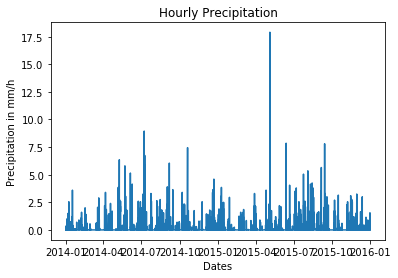

In [355]:
# Plot the precipitation by the hour in mm, so we know what we are dealing with
plt.plot(precipitation_data.index, precipitation_data['PRECIPITATION'])
plt.xlabel('Dates')
plt.ylabel('Precipitation in mm/h')
plt.title('Hourly Precipitation')

In [356]:
precipitation_data[precipitation_data['PRECIPITATION'].isna()]

,PRECIPITATION
DATE,
2015-12-31 11:00:00,NaN
2015-12-31 12:00:00,NaN
2015-12-31 13:00:00,NaN
2015-12-31 14:00:00,NaN
2015-12-31 15:00:00,NaN
2015-12-31 16:00:00,NaN
2015-12-31 17:00:00,NaN
2015-12-31 18:00:00,NaN
2015-12-31 19:00:00,NaN


In [357]:
precipitation_data['PRECIPITATION'][precipitation_data['PRECIPITATION'].isna()] = 0.0

In [359]:
precipitation_data[precipitation_data['PRECIPITATION'] == np.isnan]

,PRECIPITATION
DATE,


# Wind Data

In [234]:
# Define the Filepath
filepath_wind = 'wind_data_hamburg.csv'

# Read the .csv file
wind_data = pd.read_csv(filepath_wind, sep=';', usecols=[1,3])

# Rename the columns
wind_data.columns = ['DATE','WIND_SPEED']

# Format dates to right dtype
wind_data['DATE'] = pd.to_datetime(wind_data['DATE'], format='%Y%m%d%H')

#Filter for years 2014-2015
wind_data = wind_data[(wind_data['DATE'] > date_after) 
                                  &(wind_data['DATE']< date_before)]

# Set index as date
wind_data = wind_data.set_index('DATE')

In [235]:
wind_data.head()

,WIND_SPEED
DATE,
2014-01-01 00:00:00,5.7
2014-01-01 01:00:00,5.6
2014-01-01 02:00:00,4.9
2014-01-01 03:00:00,4.9
2014-01-01 04:00:00,5.0


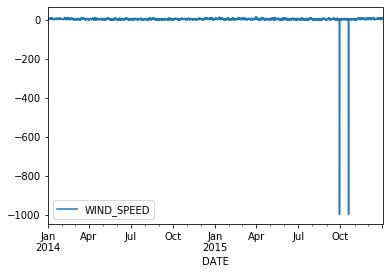

In [236]:
wind_data.plot()

In [237]:
wind_data[wind_data['WIND_SPEED']==-999].count()

WIND_SPEED    25
dtype: int64

In [238]:
wind_data[wind_data['WIND_SPEED']==-999] = 0

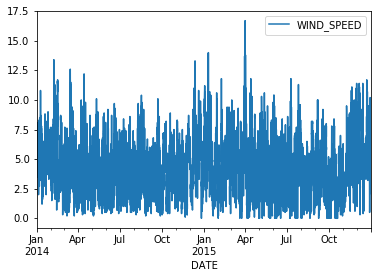

In [239]:
wind_data.plot()

In [322]:
wind_data[wind_data['WIND_SPEED'].isna()]

,WIND_SPEED
DATE,


# Visibility Data

In [181]:
# Define the Filepath
filepath_visibility = 'visibility_data_hamburg.csv'

# Read the .csv file
visibility_data = pd.read_csv(filepath_visibility, sep=';', usecols=[1,4])

# Rename the columns
visibility_data.columns = ['DATE','VISIBILITY']

# Format dates to right dtype
visibility_data['DATE'] = pd.to_datetime(visibility_data['DATE'], format='%Y%m%d%H')

#Filter for years 2014-2015
visibility_data = visibility_data[(visibility_data['DATE'] > date_after) 
                                  &(visibility_data['DATE']< date_before)]

# Set index as date
visibility_data = visibility_data.set_index('DATE')

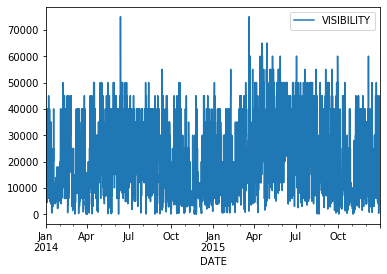

In [189]:
visibility_data.plot()

In [321]:
visibility_data[visibility_data['VISIBILITY'].isna()]

,VISIBILITY
DATE,


# Bike Bookings per Week of Year


In [90]:
weekly_data_bike = pd.Series(bike_data['DATE_BOOKING'].resample('1W').count())
weekly_data_bike = weekly_data_bike.reset_index(drop=True)

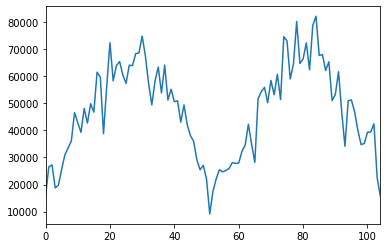

In [91]:
weekly_data_bike.plot()

In [92]:
weekly_data_bike.head()

0    15783
1    26541
2    27263
3    18754
4    19824
Name: DATE_BOOKING, dtype: int64

# Bike Bookings per Month

<BarContainer object of 12 artists>

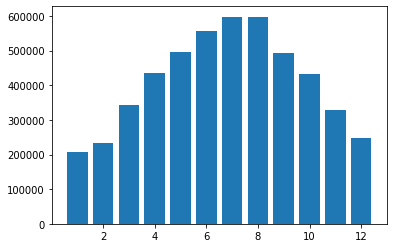

In [25]:
monthly_data_bike = []

for i in range(1,13):
    monthly_data_bike.append([i,bike_data['DATE_BOOKING'].loc[(bike_data['DATE_BOOKING'].dt.month) == i].count()])

monthly_data_bike = pd.DataFrame(monthly_data_bike)

plt.bar(monthly_data_bike[0],monthly_data_bike[1])

In [26]:
dayofweek_data_bike = []

for i in range(0,7):
    dayofweek_data_bike.append([i,bike_data['DATE_BOOKING'].loc[(bike_data['DATE_BOOKING'].dt.dayofweek) == i].count()])

dayofweek_data_bike = pd.DataFrame(dayofweek_data_bike)


In [27]:
dayofweek_data_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
0    7 non-null int64
1    7 non-null int64
dtypes: int64(2)
memory usage: 240.0 bytes


In [28]:
dayofweek_data_bike[1].cumsum()

0     696991
1    1406901
2    2156079
3    2915664
4    3676984
5    4355602
6    4967144
Name: 1, dtype: int64

# Bike bookings per day of the week

(500000, 800000)

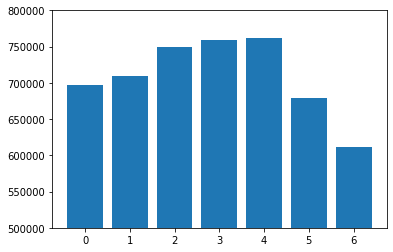

In [29]:
plt.bar(dayofweek_data_bike[0],dayofweek_data_bike[1])
plt.ylim(500000,800000)

In [30]:
hourofday_data_bike = []

for i in range(0,24):
    hourofday_data_bike.append([i,bike_data['DATE_BOOKING'].loc[(bike_data['DATE_BOOKING'].dt.hour) == i].count()])

hourofday_data_bike = pd.DataFrame(hourofday_data_bike)

In [31]:
hourofday_data_bike

,0,1
0,0,105380
1,1,78960
2,2,53020
3,3,37020
4,4,26594
5,5,25537
6,6,52639
7,7,167168
8,8,323568
9,9,222917


# Bike bookings per hour of day

<BarContainer object of 24 artists>

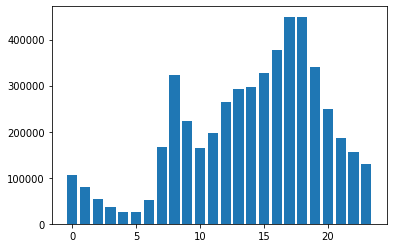

In [32]:
plt.bar(hourofday_data_bike[0],hourofday_data_bike[1])

In [33]:
bike_data['TIME_BOOKED'] = bike_data['DATE_UNTIL'] - bike_data['DATE_FROM']

In [34]:
bike_data.TIME_BOOKED.describe()

count                   4967144
mean     0 days 00:24:26.827739
std      0 days 03:10:34.307310
min             0 days 00:00:01
25%             0 days 00:07:22
50%             0 days 00:12:48
75%             0 days 00:20:53
max            92 days 03:57:55
Name: TIME_BOOKED, dtype: object

In [35]:
time_booked = bike_data.TIME_BOOKED
time_booked.index

DatetimeIndex(['2014-01-01 00:34:54', '2014-01-01 01:39:55',
               '2014-01-01 01:40:20', '2014-01-01 01:56:00',
               '2014-01-01 02:05:55', '2014-01-01 02:29:03',
               '2014-01-01 03:07:07', '2014-01-01 03:12:50',
               '2014-01-01 04:27:51', '2014-01-01 04:58:33',
               ...
               '2015-12-31 19:38:37', '2015-12-31 20:57:37',
               '2015-12-31 23:46:35', '2015-12-31 20:16:35',
               '2015-12-31 20:39:33', '2015-12-31 23:15:08',
               '2015-12-31 23:28:26', '2015-12-31 22:40:18',
               '2015-12-31 23:37:41', '2015-12-31 22:08:26'],
              dtype='datetime64[ns]', name='DATE_BOOKING', length=4967144, freq=None)

In [36]:
time_booked

DATE_BOOKING
2014-01-01 00:34:54   00:15:20
2014-01-01 01:39:55   00:17:32
2014-01-01 01:40:20   00:12:49
2014-01-01 01:56:00   00:00:41
2014-01-01 02:05:55   00:07:54
                        ...   
2015-12-31 23:15:08   00:21:45
2015-12-31 23:28:26   00:14:40
2015-12-31 22:40:18   00:08:16
2015-12-31 23:37:41   00:09:32
2015-12-31 22:08:26   00:25:06
Name: TIME_BOOKED, Length: 4967144, dtype: timedelta64[ns]

In [37]:
hourofday_data_time = []

def integer_to_time_hour(a):
    if a < 10:
        output = str('0'+str(a)+':00')
    else:
        output = str(str(a)+':00')
    return output
    
for i in range(0,24):
    hourofday_data_time.append([integer_to_time_hour(i),time_booked.loc[(bike_data['DATE_BOOKING'].dt.hour) == i].mean()/ datetime.timedelta(minutes=1)])

hourofday_data_time = pd.DataFrame(hourofday_data_time)

In [38]:
hourofday_data_time

,0,1
0,00:00,20.527261
1,01:00,20.708753
2,02:00,22.985676
3,03:00,20.776746
4,04:00,21.219511
5,05:00,18.389142
6,06:00,16.689708
7,07:00,16.932393
8,08:00,18.283801
9,09:00,22.087202


# Average length of booking in minutes per hour of day

<BarContainer object of 24 artists>

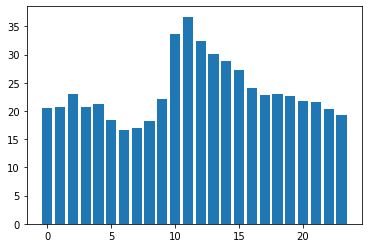

In [39]:
plt.bar(hourofday_data_time.index,hourofday_data_time[1])

In [40]:
dayofweek_data_time = []

for i in range(0,7):
    dayofweek_data_time.append([i,time_booked.loc[(bike_data['DATE_BOOKING'].dt.dayofweek) == i].mean()
                                / datetime.timedelta(minutes=1)])

dayofweek_data_time = pd.DataFrame(dayofweek_data_time)

In [41]:
dayofweek_data_time[2] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dayofweek_data_time

,0,1,2
0,0,21.416573,Mon
1,1,21.268400,Tue
2,2,21.392258,Wed
3,3,22.537333,Thu
4,4,24.741184,Fri
5,5,31.717097,Sat
6,6,29.272269,Sun


# Average length of booking per day of week

<BarContainer object of 7 artists>

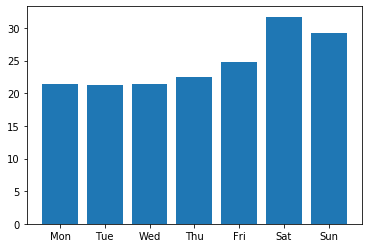

In [42]:
plt.bar(dayofweek_data_time[2],dayofweek_data_time[1])

In [43]:
monthly_data_time = []

for i in range(1,13):
    monthly_data_time.append([i,time_booked.loc[(bike_data['DATE_BOOKING'].dt.month) == i].mean()
                             / datetime.timedelta(minutes=1)])

monthly_data_time = pd.DataFrame(monthly_data_time)

monthly_data_time

,0,1
0,1,19.361096
1,2,21.269169
2,3,22.194142
3,4,24.621341
4,5,26.576400
5,6,25.722896
6,7,26.740298
7,8,28.271142
8,9,24.405386
9,10,22.857207


# Average length of booking per month

<BarContainer object of 12 artists>

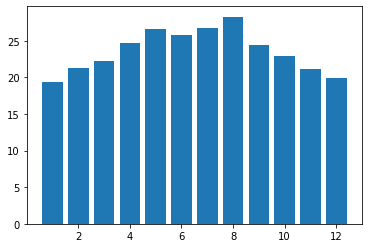

In [44]:
plt.bar(monthly_data_time[0],monthly_data_time[1])

In [45]:
# Mean start time day of week

In [46]:
time_booked

DATE_BOOKING
2014-01-01 00:34:54   00:15:20
2014-01-01 01:39:55   00:17:32
2014-01-01 01:40:20   00:12:49
2014-01-01 01:56:00   00:00:41
2014-01-01 02:05:55   00:07:54
                        ...   
2015-12-31 23:15:08   00:21:45
2015-12-31 23:28:26   00:14:40
2015-12-31 22:40:18   00:08:16
2015-12-31 23:37:41   00:09:32
2015-12-31 22:08:26   00:25:06
Name: TIME_BOOKED, Length: 4967144, dtype: timedelta64[ns]

# Average Booking Start Time per Day of Week (in hours)

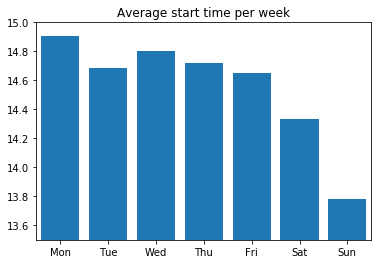

In [47]:
dayofweek_mean = []
daysofweek = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(0,7):
    dayofweek_mean.append(bike_data['DATE_FROM'].loc[(bike_data['DATE_FROM'].dt.dayofweek) == i])

dayofweek_averages = []
avg = 0

for i in range(0,7):
    for elem in dayofweek_mean[i]:
        avg += (elem.hour*3600+elem.minute*60+elem.second)
    dayofweek_averages.append(avg/len(dayofweek_mean[i])/60/60)
    avg = 0

dayofweek_averages = pd.Series(dayofweek_averages)

plt.bar(daysofweek, dayofweek_averages)
plt.axis([-0.5,6.5,13.5, 15])
plt.title('Average start time per week')
plt.show()

# Average Start Time per Month (in hours)

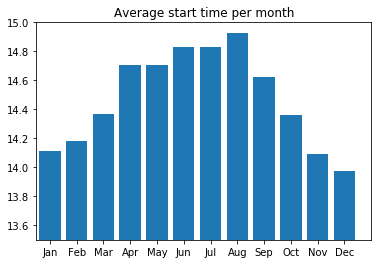

In [48]:
monthly_mean = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(1,13):
    monthly_mean.append(bike_data['DATE_FROM'].loc[(bike_data['DATE_FROM'].dt.month) == i])

monthly_averages = []
avg = 0

for i in range(0,12):
    for elem in monthly_mean[i]:
        avg += (elem.hour*3600+elem.minute*60+elem.second)
    monthly_averages.append(avg/len(monthly_mean[i])/60/60)
    avg = 0

monthly_averages = pd.Series(monthly_averages)

plt.bar(months, monthly_averages)
plt.axis([-0.5,12,13.5, 15])
plt.title('Average start time per month')
plt.show()

# Bike Bookings - Temperature

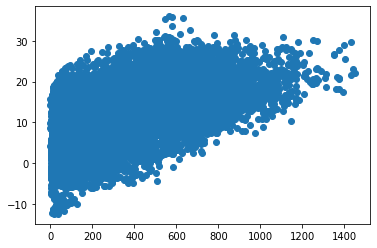

In [243]:
plt.scatter(bike_data['DATE_BOOKING'].resample('1H').count(), temperature_data['TEMPERATURE'])

# Bike Bookings - Precipitation

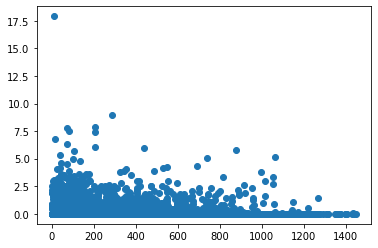

In [360]:
plt.scatter(bike_data['DATE_BOOKING'].resample('1H').count(), precipitation_data['PRECIPITATION'])

# Bike Bookings - Visibility

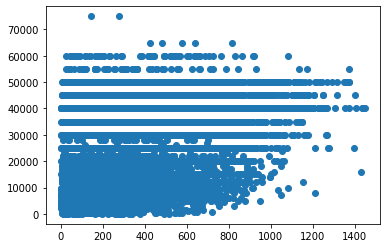

In [260]:
plt.scatter(bike_data['DATE_BOOKING'].resample('1H').count(), visibility_data['VISIBILITY'])

# Bike Bookings - Wind

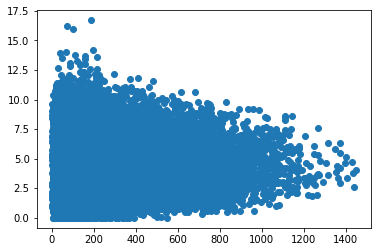

In [261]:
plt.scatter(bike_data['DATE_BOOKING'].resample('1H').count(), wind_data['WIND_SPEED'])

# Patterns Start and End Location

In [49]:
bike_data = bike_data.reset_index(drop=True)

unique_start_location = pd.Series(bike_data.START_RENTAL_ZONE.unique())
unique_end_location = pd.Series(bike_data.END_RENTAL_ZONE.unique())

In [50]:
unique_end_location = unique_end_location.sort_values()

In [51]:
bike_data['START_RENTAL_ZONE'].describe()

count                      4967003
unique                         188
top       Allende-Platz/Grindelhof
freq                        108582
Name: START_RENTAL_ZONE, dtype: object

In [52]:
bike_data.index = bike_data.DATE_FROM

In [53]:
start_rental_zone = pd.Series(bike_data.groupby('START_RENTAL_ZONE')['DATE_BOOKING'].count())

In [54]:
start_rental_zone.sort_values(ascending = False)[0:10]

START_RENTAL_ZONE
Allende-Platz/Grindelhof                 108582
Schulterblatt/Eifflerstraße               97741
Jungfernstieg / Ballindamm                77697
Goldbekplatz / Semperstraße               76981
Neuer Pferdemarkt / Beim Grünen Jäger     75337
Jarrestraße / Rambatzweg                  73937
Mundsburg / Schürbeker Straße             73518
Lange Reihe / Lohmühlenpark               72334
Eduard-Rhein-Ufer / Schwanenwik           71488
Landungsbrücke/Hafentor                   71348
Name: DATE_BOOKING, dtype: int64

<img src="hamburg_most_used_start_locations.png">

In [55]:
end_rental_zone = pd.Series(bike_data.groupby('END_RENTAL_ZONE')['DATE_BOOKING'].count())

In [56]:
end_rental_zone.sort_values(ascending = False)[0:10]

END_RENTAL_ZONE
Allende-Platz/Grindelhof                 109754
Schulterblatt/Eifflerstraße               97680
Jungfernstieg / Ballindamm                81811
Landungsbrücke/Hafentor                   79233
Goldbekplatz / Semperstraße               77748
Jarrestraße / Rambatzweg                  75641
Neuer Pferdemarkt / Beim Grünen Jäger     75390
Mundsburg / Schürbeker Straße             73663
Eduard-Rhein-Ufer / Schwanenwik           72802
Lange Reihe / Lohmühlenpark               72602
Name: DATE_BOOKING, dtype: int64

In [57]:
bike_data.groupby('START_RENTAL_ZONE')['TIME_BOOKED'].sum().sort_values(ascending=False)[0:10]

START_RENTAL_ZONE
Landungsbrücke/Hafentor                  1960 days 05:19:26
Schulterblatt/Eifflerstraße              1523 days 03:37:00
Allende-Platz/Grindelhof                 1520 days 20:39:42
Jungfernstieg / Neuer Jungfernstieg      1453 days 05:46:06
Jungfernstieg / Ballindamm               1443 days 08:35:35
Hauptbahnhof Ost / Hachmannplatz         1421 days 08:40:08
Hauptbahnhof West / Glockengießer Wall   1385 days 20:50:04
Goldbekplatz / Semperstraße              1374 days 07:44:36
Eduard-Rhein-Ufer / Schwanenwik          1251 days 16:45:05
Jarrestraße / Rambatzweg                 1230 days 14:08:04
Name: TIME_BOOKED, dtype: timedelta64[ns]

In [58]:
location_patterns = pd.DataFrame({
    'START+END': bike_data.START_RENTAL_ZONE+'-->'+bike_data.END_RENTAL_ZONE,
    'TIME' : bike_data.TIME_BOOKED
})

In [59]:
location_patterns.groupby('START+END')['TIME'].sum().sort_values(ascending= False)[0:20]

START+END
Landungsbrücke/Hafentor-->Landungsbrücke/Hafentor                                 384 days 13:43:36
BSCTerminal FFM 2.OG R 2.21-->BSCTerminal FFM 2.OG R 2.21                         305 days 04:55:34
Goldbekplatz / Semperstraße-->Goldbekplatz / Semperstraße                         245 days 04:32:30
Funkbox-BSC-HH-->Funkbox-BSC-HH                                                   212 days 14:26:54
Kümmellstraße / Robert-Koch-Straße-->Kümmellstraße / Robert-Koch-Straße           207 days 09:17:59
Methfesselstraße/Luruper Weg-->Methfesselstraße/Luruper Weg                       204 days 10:22:06
Jungfernstieg / Neuer Jungfernstieg-->Jungfernstieg / Neuer Jungfernstieg         192 days 14:10:24
Horner Rennbahn/ Meurer Weg-->Funkbox-BSC-HH                                      192 days 02:44:11
Hauptbahnhof Ost / Hachmannplatz-->Hauptbahnhof Ost / Hachmannplatz               189 days 09:48:07
Eduard-Rhein-Ufer / Schwanenwik-->Eduard-Rhein-Ufer / Schwanenwik                 183 days

<BarContainer object of 7 artists>

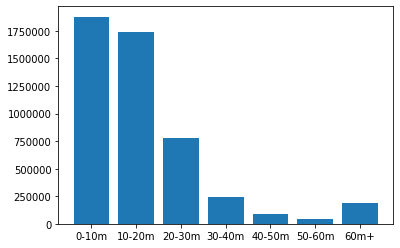

In [60]:
time_intervals = ['0-10m', '10-20m', '20-30m', '30-40m', '40-50m', '50-60m', '60m+']
time_intervals_count = [bike_data[bike_data['TIME_BOOKED'] <= pd.Timedelta(10, unit='m')].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(10, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(20, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(20, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(30, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(30, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(40, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(40, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(50, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(50, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(60, unit='m'))].count()[0],
                        bike_data[bike_data['TIME_BOOKED'] > pd.Timedelta(60, unit='m')].count()[0]]

time_intervals_data = pd.DataFrame({'TIME_INTERVAL': time_intervals,
                                    'COUNT': time_intervals_count})

plt.bar(time_intervals_data['TIME_INTERVAL'], time_intervals_data['COUNT'])

<BarContainer object of 7 artists>

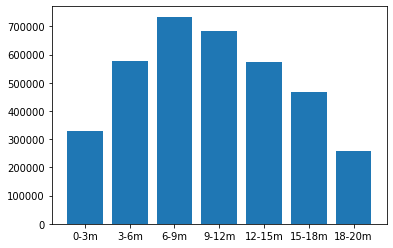

In [61]:
time_intervals_detailed = ['0-3m', '3-6m', '6-9m', '9-12m', '12-15m', '15-18m', '18-20m']
time_intervals_detailed_count = [bike_data[bike_data['TIME_BOOKED'] <= pd.Timedelta(3, unit='m')].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(3, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(6, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(6, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(9, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(9, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(12, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(12, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(15, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(15, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(18, unit='m'))].count()[0],
                        bike_data[(bike_data['TIME_BOOKED'] > pd.Timedelta(18, unit='m')) &
                                 (bike_data['TIME_BOOKED'] <= pd.Timedelta(20, unit='m'))].count()[0]]

time_intervals_detailed_data = pd.DataFrame({'TIME_INTERVAL': time_intervals_detailed,
                                    'COUNT': time_intervals_detailed_count})

plt.bar(time_intervals_detailed_data['TIME_INTERVAL'], time_intervals_detailed_data['COUNT'])

Most bookings tend to be under an hour. <br>
There are only <b>3.8%</b> (188863 / 4967144 = 0.038) bookings which lasted <b>over one hour</b>. <br>
<b>38.7%</b> of bookings were used <b>0-10 min</b> which is the highest count using 10min intervals ( 1879106 / 4967144 = 0.378 = 37.8%). <br>
More specifically going into smaller 3 minute intervals under 20min time booked, the most used interval is the <b>6-9min</b> range with <b>14.8%</b> of all bookings (734036 / 4967144 = 0.148).<br>
Zero to twenty minutes of time booked is the majority with <b>72.9%</b> ((1879106+1743423) / 4967144 = 0.729).

In [62]:
time_intervals_count

[1879106, 1743423, 778203, 241305, 89781, 46463, 188863]

# Cluster Analysis

In [64]:
locations_dict = dict()
i = 1
for item in data_january_2014['START_RENTAL_ZONE'].unique():
    locations_dict[item] = i
    i += 1

timestamp_before_feb_2014 = pd.Timestamp('2014-01-31 23:59:59')    
data_january_2014 = bike_data[bike_data['DATE_FROM'] < timestamp_before_feb_2014]

X = pd.DataFrame({
    'START' : (data_january_2014['DATE_FROM'].dt.hour)*60+(data_january_2014['DATE_FROM'].dt.minute),
    'LENGTH': data_january_2014['TIME_BOOKED'] / datetime.timedelta(minutes = 1)})
    #'LOCATION_START' : data_january_2014['START_RENTAL_ZONE']})

#X['LOCATION_START']= X['LOCATION_START'].map(locations_dict) 
X.dropna(axis = 0)
X = X.reset_index(drop=True)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df = X_scaled_df.reset_index(drop=True)
X_scaled_df.head()

NameError: name 'data_january_2014' is not defined

In [ ]:
k_max = 20
clusters = []
losses = []

def run_k_loop():
    for k in range(k_max):
        model = KMeans(n_clusters=k+1)
        model.fit(X_scaled)
        clusters.append(k+1)
        losses.append(model.inertia_)

In [ ]:
#%timeit run_k_loop()

In [ ]:
#plt.plot(clusters, losses)
#plt.show()

In [ ]:
#four_means = KMeans(n_clusters=3)
#four_means.fit(X_scaled)
#X['three_means'] = four_means.predict(X_scaled)

In [ ]:
#fig, ax = plt.subplots()

#ax.scatter(x = X_scaled_df.LENGTH, y = X_scaled_df.START, c = X['three_means'])

In [ ]:
#X.tail()

# Predictive Analysis

In [66]:
dayofweek_data_predictive_analysis = pd.Series(dayofweek_averages / dayofweek_averages.sum())

In [67]:
monthly_data_bike_predictive_analysis = pd.Series(monthly_data_bike[1] / monthly_data_bike[1].sum())

In [94]:
weekly_data_bike_predictive_analysis

0      0.003177
1      0.005343
2      0.005489
3      0.003776
4      0.003991
         ...   
100    0.007918
101    0.007933
102    0.008542
103    0.004535
104    0.003148
Name: DATE_BOOKING, Length: 105, dtype: float64

In [93]:
weekly_data_bike_predictive_analysis = pd.Series(weekly_data_bike / weekly_data_bike.sum())

In [95]:
hourofday_data_bike_predictive_analysis = pd.Series(hourofday_data_bike[1] / hourofday_data_bike[1].sum())

In [332]:
precipitation_data[precipitation_data['PRECIPITATION'] == np.isnan]

,DATE,PRECIPITATION


In [361]:
data = pd.DataFrame({'DATE' : pd.date_range(start='1/1/2014', end='31/12/2015 23:00:00', freq='H')})

data.index = data.DATE
del data['DATE']

data['TEMPERATURE'] = temperature_data['TEMPERATURE']
data['PRECIPITATION'] = precipitation_data['PRECIPITATION']
data['BOOKING_COUNT'] = bike_data['DATE_FROM'].resample('1H').count()
data['VISIBILITY'] = visibility_data['VISIBILITY']
data['WIND'] = wind_data['WIND_SPEED']

data['HOURLY_%'] = pd.Series(hourofday_data_bike_predictive_analysis.loc[data.index.hour].values, index = data.index.values)
data['DAYOFWEEK_%'] = pd.Series(dayofweek_data_predictive_analysis.loc[data.index.dayofweek].values, index = data.index.values)
data['MONTHLY_%'] = pd.Series(monthly_data_bike_predictive_analysis.loc[data.index.month-1].values, index = data.index.values)
data['WEEKLY_%'] = pd.Series(weekly_data_bike_predictive_analysis.loc[data.index.week].values, index = data.index.values)

data['OVERALL_%'] = data['HOURLY_%'] * data['DAYOFWEEK_%'] * data['MONTHLY_%'] * data['WEEKLY_%']


In [362]:
data.head()

,TEMPERATURE,PRECIPITATION,BOOKING_COUNT,VISIBILITY,WIND,HOURLY_%,DAYOFWEEK_%,MONTHLY_%,WEEKLY_%,OVERALL_%
DATE,,,,,,,,,,
2014-01-01 00:00:00,2.1,0.0,90,6000,5.7,0.021215,0.145267,0.041968,0.005343,6.911055e-07
2014-01-01 01:00:00,2.0,0.0,115,20000,5.6,0.015896,0.145267,0.041968,0.005343,5.178372e-07
2014-01-01 02:00:00,2.1,0.0,128,25000,4.9,0.010674,0.145267,0.041968,0.005343,3.477169e-07
2014-01-01 03:00:00,1.6,0.0,160,25000,4.9,0.007453,0.145267,0.041968,0.005343,2.427854e-07
2014-01-01 04:00:00,1.4,0.0,154,25000,5.0,0.005354,0.145267,0.041968,0.005343,1.744094e-07


In [367]:
X = data.drop(['BOOKING_COUNT','HOURLY_%','WEEKLY_%','MONTHLY_%','DAYOFWEEK_%','WIND','VISIBILITY','PRECIPITATION'], axis = 1)
Y = data[['BOOKING_COUNT']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

# define our intput
X2 = sm.add_constant(X)

# Get multiple predictions
y_predict = regression_model.predict(X_test)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()


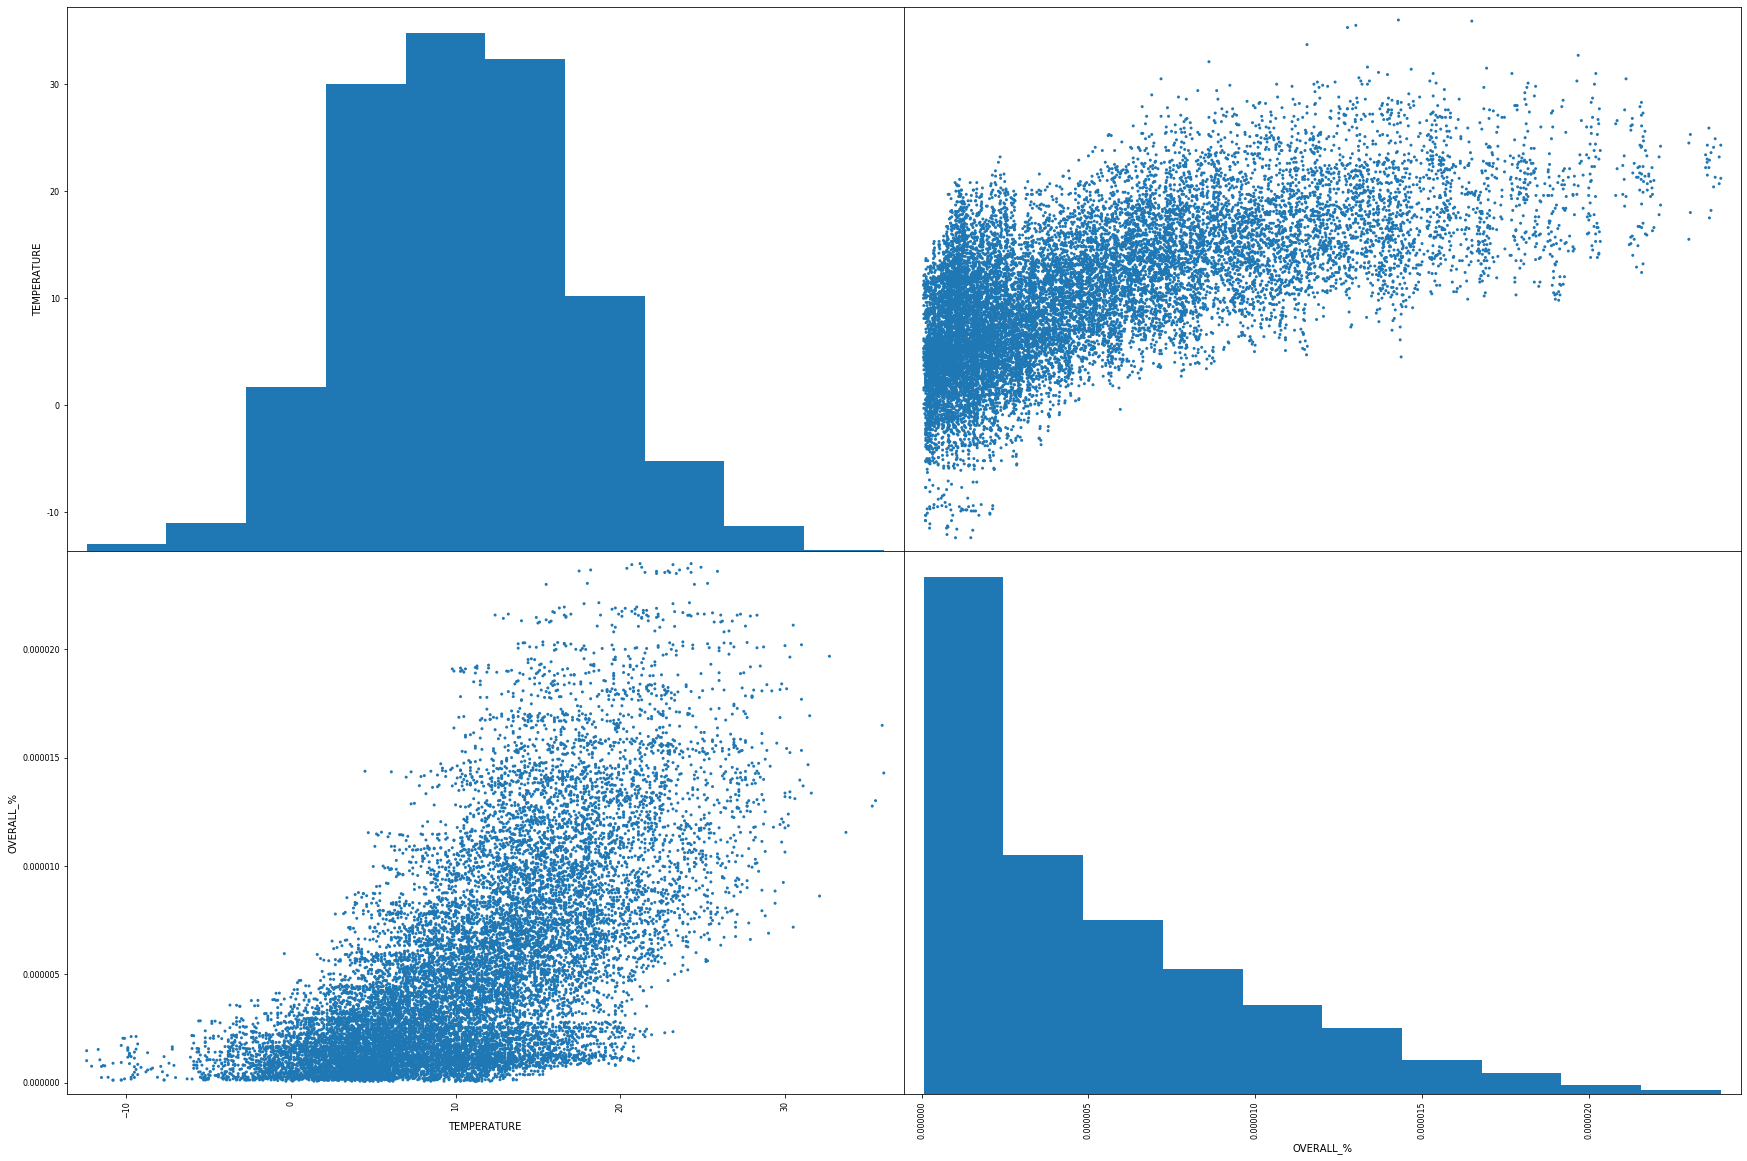

In [368]:
# define the plot
pd.plotting.scatter_matrix(X, alpha = 1, figsize = (30, 20))

# show the plot
plt.show()

In [369]:
# print out a summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:          BOOKING_COUNT   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 1.531e+04
Date:                Sun, 05 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:03:47   Log-Likelihood:            -1.1250e+05
No. Observations:               17520   AIC:                         2.250e+05
Df Residuals:                   17517   BIC:                         2.250e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.0490      2.089     28.739      

In [366]:
import math
# calculate the mean squared error
model_mse = mean_squared_error(y_test, y_predict)

# calculate the mean absolute error
model_mae = mean_absolute_error(y_test, y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 2.22e+04
MAE 1.1e+02
RMSE 1.49e+02


In [303]:
# estimate the p-values
est.pvalues

const            1.610139e-177
TEMPERATURE       1.231025e-13
PRECIPITATION              NaN
OVERALL_%         0.000000e+00
dtype: float64

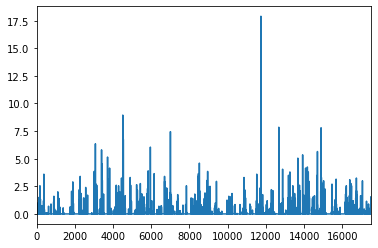

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [ ]:
plt.scatter(data['BOOKING_COUNT'], data['TEMPERATURE'], marker='x')

In [ ]:
temp_model = LinearRegression(fit_intercept =True)
temp_model.fit(data['BOOKING_COUNT'].values.reshape(-1,1), data['TEMPERATURE'])
temp_model_pred = temp_model.predict(data['BOOKING_COUNT'].values.reshape(-1,1))

In [ ]:
plt.scatter(data['BOOKING_COUNT'], data['TEMPERATURE'], marker='x', c='r')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
Z = np.linspace(0,1400)
T = temp_model.intercept_ + temp_model.coef_*Z
plt.xlim(xlim)
plt.ylim(ylim)
plt.plot(Z,T)

plt.show()

print(temp_model.coef_, temp_model.intercept_)
print('The R^2 of linear regression is: ',r2_score(data['TEMPERATURE'], temp_model_pred))

In [ ]:
plt.scatter(data['BOOKING_COUNT'], data['PRECIPITATION'], marker='x')

In [ ]:
prec_model = LinearRegression(fit_intercept =True)
prec_model.fit(data['BOOKING_COUNT'].values.reshape(-1,1), data['PRECIPITATION'])
prec_model_pred = prec_model.predict(data['BOOKING_COUNT'].values.reshape(-1,1))

In [ ]:
plt.scatter(data['BOOKING_COUNT'], data['PRECIPITATION'], marker='x', c='r')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
Z = np.linspace(0,1400)
T = prec_model.intercept_ + prec_model.coef_*Z
plt.xlim(xlim)
plt.ylim(ylim)
plt.plot(Z,T)

plt.show()

In [ ]:
print(prec_model.coef_, prec_model.intercept_)
print('The R^2 of linear regression is: ',r2_score(data['PRECIPITATION'], prec_model_pred))

In [ ]:
data['BOOKING_COUNT'].corr(data['TEMPERATURE'])

In [ ]:
sm_x = [data['TEMPERATURE'], data['PRECIPITATION']]

X2 = sm.add_constant(sm_x)
est = sm.OLS(data['BOOKING_COUNT'], X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
data_daily = pd.DataFrame({'DATE' : pd.date_range(start='1/1/2014', end='31/12/2015 23:00:00', freq='D')})

data_daily.index = data_daily.DATE
temperature_data.index = temperature_data['DATE']
precipitation_data.index = precipitation_data['DATE']

data_daily['TEMPERATURE'] = temperature_data['TEMPERATURE'].resample('1D').mean()
data_daily['PRECIPITATION'] = precipitation_data['PRECIPITATION'].resample('1D').mean()
data_daily['BOOKING_COUNT'] = bike_data['DATE_FROM'].resample('1D').count()

data_daily['PRECIPITATION'] = data_daily['PRECIPITATION'].fillna(0)

data_daily['DAY_OF_WEEK'] = dayofweek_data_bike[1][data_daily['DATE'].dt.dayofweek]

del data_daily['DATE']

In [ ]:
dayofweek_data_bike[1][6]

In [ ]:
plt.scatter(data_daily['BOOKING_COUNT'], data_daily['DAY_OF_WEEK'], marker='x')

In [ ]:
plt.scatter(data_daily['BOOKING_COUNT'], data_daily['TEMPERATURE'], marker='x')

In [ ]:
plt.scatter(data_daily['BOOKING_COUNT'], data_daily['PRECIPITATION'], marker='x')

In [ ]:
temp_model_daily = LinearRegression(fit_intercept =True)
temp_model_daily.fit(data_daily['BOOKING_COUNT'].values.reshape(-1,1), data_daily['TEMPERATURE'])
temp_model_daily_pred = temp_model_daily.predict(data_daily['BOOKING_COUNT'].values.reshape(-1,1))

In [ ]:
plt.scatter(data_daily['BOOKING_COUNT'], data_daily['TEMPERATURE'], marker='x', c='r')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
Z = np.linspace(0,14000)
T = temp_model_daily.intercept_ + temp_model_daily.coef_*Z
plt.xlim(xlim)
plt.ylim(ylim)
plt.plot(Z,T)

plt.show()

print(temp_model_daily.coef_, temp_model_daily.intercept_)
print('The R^2 of linear regression is: ',r2_score(data_daily['TEMPERATURE'], temp_model_daily_pred))